# FCNs on the parity problem
In this notebook, we train ReLU and sinusoidal FCNs on the parity problem, finding that the sinusoidal FCNs outperform the ReLU FCNs significantly as suggested by their respective NTKs.

## Imports and installs

In [1]:
!pip install -q git+https://www.github.com/google/neural-tangents

import os
import sys

if os.path.isdir('/content/eigenlearning'):
  !rm -r '/content/eigenlearning'
!git clone -q https://github.com/james-simon/eigenlearning.git
sys.path.insert(0,'/content/eigenlearning')

     |████████████████████████████████| 99 kB 2.4 MB/s 


In [2]:
import jax
from jax import grad
import jax.numpy as np
import jax.random as random

import scipy
from scipy.misc import derivative
import scipy.integrate as integrate
import scipy.special as special

import matplotlib.pyplot as plt

import neural_tangents as nt

import hypercube
import measures
import utils

/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [3]:
key = jax.random.PRNGKey(17)

In [4]:
def fcut(x, a=3):
  return ('{:.'+str(a)+'f}').format(x)

## Load parity data

In [5]:
n_bits = 11
n_train = 2**(n_bits-1)
n_test = 2**(n_bits-1)

key, subkey = random.split(key)
bitsets, [targets] = hypercube.get_hypercube_dataset(n_bits, [{n_bits : 1}], full=False, n=2**n_bits, subkey=subkey)

train_X, train_y = bitsets[:n_train], targets[:n_train]
test_X, test_y = bitsets[n_train:(n_train+n_test)], targets[n_train:(n_train+n_test)]

dataset = (train_X, train_y), (test_X, test_y)

In [6]:
train_y, test_y = -train_y, -test_y

In [7]:
def unit_circle_samples(n, cosine_spaced=False):
  if cosine_spaced:
    cosines = np.linspace(1, -1, n)
    sines = (1 - cosines**2)**.5
    X = np.stack([cosines, sines]).T * 2**.5
    thetas = np.arccos(cosines)
  
  else:
    thetas = np.linspace(0, np.pi, n)
    cosines = np.cos(thetas)
    sines = np.sin(thetas)
    X = np.stack([cosines, sines]).T * 2**.5

  return X, thetas

In [8]:
X, thetas = unit_circle_samples(100)

## Putting it all together

### Create kernels

In [9]:
net_fns, results = {}, {}

In [10]:
net_fns['4HL ReLU'] = utils.get_net_fns(128, 1, n_hidden_layers=4, W_std=2**.5, b_std=.1)

In [11]:
%%capture
phi = lambda z : .5 * np.sin(6 * z)
net_fns['1HL phi'] = utils.get_net_fns(128, 1, n_hidden_layers=1, W_std=1, b_std=0, phi=phi, phi_deg=70)

In [12]:
%%capture
phi = lambda z : 10 * np.sin(6 * z)
net_fns['1HL phi b'] = utils.get_net_fns(128, 1, n_hidden_layers=1, W_std=1, b_std=0, phi=phi)

In [13]:
phi_ntk_coeffs = .25 * np.exp(-6**2) * np.array([6.**(2*k) * (1 + k) / special.factorial(k) if k%2==1 else 0 for k in range(1, 100, 2)])
phi_ntk_coeffs.sum()

DeviceArray(4.625, dtype=float32)

### Plot kernels

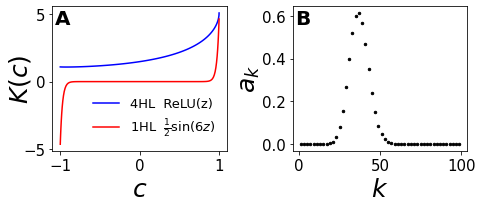

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(7,3))


ax = axs[0]
Ks = net_fns['4HL ReLU'][2](X, X[:1], 'ntk')[:,0]
ax.plot(X[:,0] / 2**.5, Ks, label='4HL  ReLU(z)', color=(0,0,1))

Ks = net_fns['1HL phi'][2](X, X[:1], 'ntk')[:,0]
ax.plot(X[:,0] / 2**.5, Ks, label='1HL  $\\frac{1}{2}\sin(6z)$', color=(1,0,0))

ax.legend(fontsize=13, frameon=False)

ax.tick_params(axis='both', labelsize=15)
ax.set_xlabel('$c$', fontsize=25)
ax.set_ylabel('$K(c)$', fontsize=25, labelpad=-10)


ax = axs[1]
ax.scatter(np.array(range(len(phi_ntk_coeffs))) * 2 + 1, phi_ntk_coeffs, color=(0,0,0), s=6)

ax.tick_params(axis='both', labelsize=15)
ax.set_xlabel('$k$', fontsize=25)
ax.set_ylabel('$a_k$', fontsize=25, labelpad=0)

for i in range(len(axs)):
  axs[i].text(.06, .88, 'AB'[i], transform=axs[i].transAxes, size=20, weight='bold', ha='center')

fig.tight_layout()

plt.savefig('parity_kernels.pdf', transparent=True, dpi=300, bbox_inches='tight')

### Train nets

In [ ]:
results['4HL ReLU'] = []

n_trials, n_epochs = 30, 10000

for _ in range(n_trials):
  key, subkey = random.split(key)
  res = measures.net_measures(net_fns['4HL ReLU'], dataset, [], n_epochs=n_epochs, lr=.1, subkey=subkey, print_every=n_epochs//10, compute_acc=True, stop_mse=.001)
  results['4HL ReLU'] += [res]
  print()

In [ ]:
results['1HL phi'] = []

n_trials, n_epochs = 30, 4000

for _ in range(n_trials):
  key, subkey = random.split(key)
  res = measures.net_measures(net_fns['1HL phi'], dataset, [], n_epochs=n_epochs, lr=.1, subkey=subkey, print_every=n_epochs//10, compute_acc=True, stop_mse=.001)
  results['1HL phi'] += [res]
  print()

In [ ]:
results['1HL phi b'] = []

n_trials, n_epochs = 30, 100

for _ in range(n_trials):
  key, subkey = random.split(key)
  res = measures.net_measures(net_fns['1HL phi b'], dataset, [], n_epochs=n_epochs, lr=.01, subkey=subkey, print_every=n_epochs//10, compute_acc=True, stop_mse=.001)
  results['1HL phi b'] += [res]
  print()

### Print results

In [18]:
for arch in results:
  mses = np.array([res['mse'] for res in results[arch]])
  accs = np.array([res['acc'] for res in results[arch]])
  
  print(f'{arch}\t---\t mse: {mses.mean().item(), mses.std().item()} \t acc: {accs.mean().item(), accs.std().item()}')

4HL ReLU	---	 mse: (2.8161532878875732, 0.12086958438158035) 	 acc: (0.29371747374534607, 0.01597246155142784)
1HL phi	---	 mse: (0.02070895954966545, 0.0037197526544332504) 	 acc: (1.0, 0.0)
1HL phi b	---	 mse: (0.667985737323761, 0.33163726329803467) 	 acc: (0.8204752802848816, 0.0854962021112442)


In [19]:
for arch in results:
  mses = np.array([res['mse'] for res in results[arch]])
  accs = np.array([res['acc'] for res in results[arch]])
  
  print(f'{arch} \t---\t ${fcut(mses.mean().item())} \\pm {fcut(mses.std().item())}$ & ${fcut(100 * accs.mean().item())} \\pm {fcut(100 * accs.std().item())}$')

4HL ReLU 	---	 $2.816 \pm 0.121$ & $29.372 \pm 1.597$
1HL phi 	---	 $0.021 \pm 0.004$ & $100.000 \pm 0.000$
1HL phi b 	---	 $0.668 \pm 0.332$ & $82.048 \pm 8.550$
